In [ ]:
#Import requires libraries

from osgeo import ogr, gdal, osr
import numpy as np
import os
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Input Raster and Vector Paths
#Image-2019
path_B5_2019= '/content/drive/My Drive/Blue Sky Analytics/2019/LC08_L1TP_147040_20190505_20190520_01_T1_B5.TIF'
path_B4_2019= '/content/drive/My Drive/Blue Sky Analytics/2019/LC08_L1TP_147040_20190505_20190520_01_T1_B4.TIF'

#Image-2022
path_B5_2022 = '/content/drive/My Drive/Blue Sky Analytics/2022/LC08_L1TP_147040_20211220_20211229_01_T1_B5.TIF'
path_B4_2022 = '/content/drive/My Drive/Blue Sky Analytics/2022/LC08_L1TP_147040_20211220_20211229_01_T1_B4.TIF'

In [ ]:
#Output Files
#Output NDVI Rasters 
path_NDVI_2019 = '/content/drive/My Drive/Blue Sky Analytics/NDVI2019.tif'
path_NDVI_2022 = '/content/drive/My Drive/Blue Sky Analytics/NDVI2022.tif'
path_NDVIChange_19_22 = '/content/drive/My Drive/Blue Sky Analytics/NDVIChange_19_22.tif'

#NDVI Contours
contours_NDVIChange_19_22 = '/content/drive/My Drive/Blue Sky Analytics/NDVIChange_19_22.shp'

Open the Landsat image bands with GDAL:

In this part we open the red (Band 4) and near infrared NIR (Band 5) with commands of the GDAL library and then we read the images as matrix arrays with float numbers of 32 bits.

In [ ]:
#Open raster bands
B5_2019 = gdal.Open(path_B5_2019)
B4_2019 = gdal.Open(path_B4_2019)
B5_2022 = gdal.Open(path_B5_2022)
B4_2022 = gdal.Open(path_B4_2022)

In [ ]:
#Read bands as matrix arrays
B52019_Data = B5_2019.GetRasterBand(1).ReadAsArray().astype(np.float32)
B42019_Data = B4_2019.GetRasterBand(1).ReadAsArray().astype(np.float32)
B52022_Data = B5_2022.GetRasterBand(1).ReadAsArray().astype(np.float32)
B42022_Data = B4_2022.GetRasterBand(1).ReadAsArray().astype(np.float32)

### Check for projection and shape


In [ ]:
print(B5_2022.GetProjection()[:80])
print(B5_2019.GetProjection()[:80])
if B5_2022.GetProjection()[:80]==B5_2019.GetProjection()[:80]: print('PROJECTION OK')

PROJCS["WGS 84 / UTM zone 43N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84
PROJCS["WGS 84 / UTM zone 43N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84
PROJECTION OK


In [ ]:
print(B52022_Data.shape)
print(B52019_Data.shape)
if B52022_Data.shape==B52019_Data.shape: print('Array Size OK')

(7741, 7591)
(7741, 7591)
Array Size OK


In [ ]:
print(B5_2022.GetGeoTransform())
print(B5_2019.GetGeoTransform())

(520185.0, 30.0, 0.0, 3309915.0, 0.0, -30.0)
(520785.0, 30.0, 0.0, 3309915.0, 0.0, -30.0)


Get geotransformation parameters

In [ ]:
geotransform = B5_2022.GetGeoTransform()

originX,pixelWidth,empty,finalY,empty2,pixelHeight=geotransform
cols =  B5_2022.RasterXSize
rows =  B5_2022.RasterYSize

In [ ]:
projection = B5_2022.GetProjection()
projection

'PROJCS["WGS 84 / UTM zone 43N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",75],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32643"]]'

In [ ]:
finalX = originX + pixelWidth * cols
originY = finalY + pixelHeight * rows

Compute the NDVI and store them as a different file

In [ ]:
ndvi2022 = np.divide(B52022_Data - B42022_Data, B52022_Data+ B42022_Data,where=(B52022_Data - B42022_Data)!=0)
ndvi2022[ndvi2022 == 0] = -999

In [ ]:
ndvi2019 = np.divide(B52019_Data - B42019_Data, B52019_Data+ B42019_Data,where=(B52019_Data - B42019_Data)!=0)
ndvi2019[ndvi2019 == 0] = -999

In [ ]:
def saveRaster(dataset,datasetPath,cols,rows,projection):
    rasterSet = gdal.GetDriverByName('GTiff').Create(datasetPath, cols, rows,1,gdal.GDT_Float32)
    rasterSet.SetProjection(projection)
    rasterSet.SetGeoTransform(geotransform)
    rasterSet.GetRasterBand(1).WriteArray(dataset)
    rasterSet.GetRasterBand(1).SetNoDataValue(-999)
    rasterSet = None

In [ ]:
saveRaster(ndvi2022,path_NDVI_2022,cols,rows,projection)

saveRaster(ndvi2019,path_NDVI_2019,cols,rows,projection)

Plot NDVI Images

In [ ]:
extentArray = [originX,finalX,originY,finalY]
def plotNDVI(ndviImage,extentArray,vmin,cmap):
    ndvi = gdal.Open(ndviImage)
    ds2019 = ndvi.ReadAsArray()
    plt.figure(figsize=(20,15))
    im = plt.imshow(ds2019, vmin=vmin, cmap=cmap, extent=extentArray)#
    plt.colorbar(im, fraction=0.015)
    plt.xlabel('Este')
    plt.ylabel('Norte')
    plt.show()

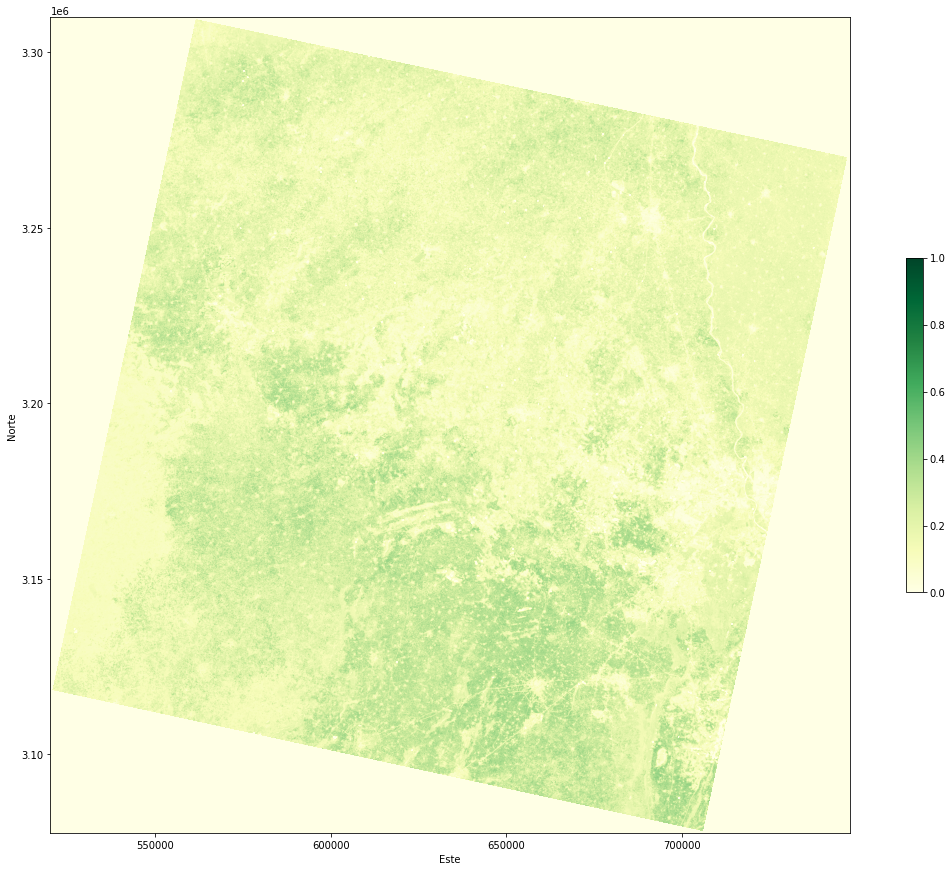

In [ ]:
plotNDVI(path_NDVI_2022,extentArray,0,'YlGn')

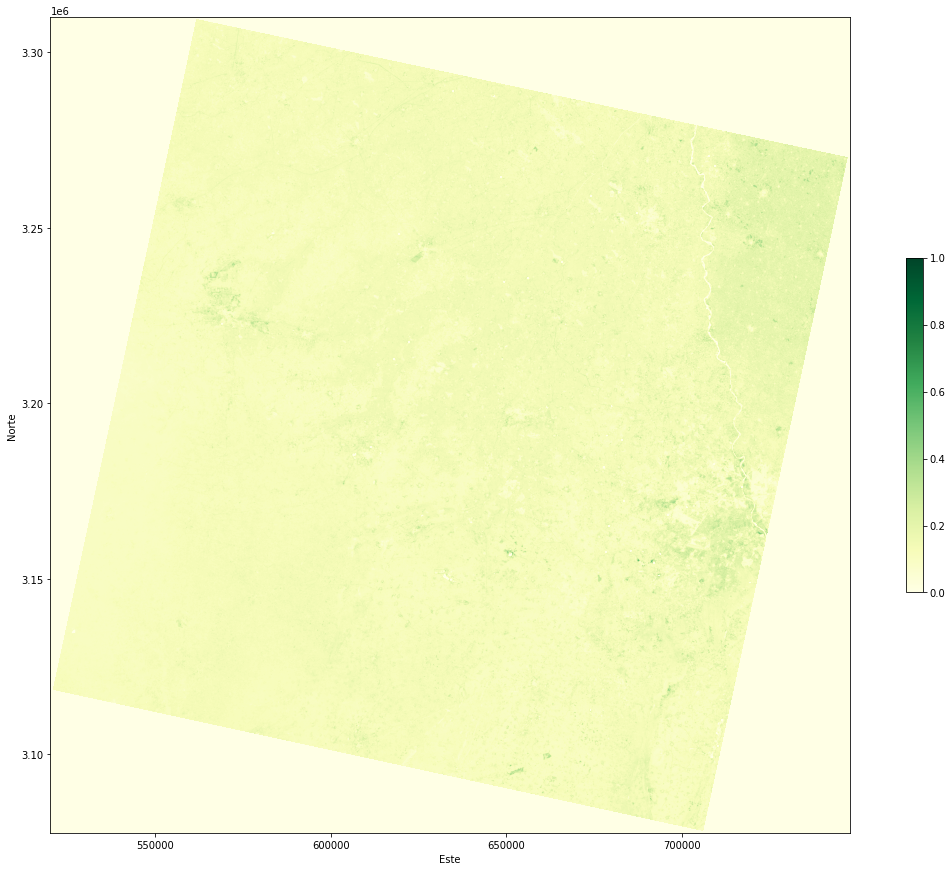

In [ ]:
plotNDVI(path_NDVI_2019,extentArray,0,'YlGn')

Create a land cover change image


In [ ]:
ndviChange = ndvi2019-ndvi2022
ndviChange = np.where((ndvi2022>-999) & (ndvi2019>-999),ndviChange,-999)
ndviChange

array([[-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       ...,
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.]], dtype=float32)

In [ ]:
saveRaster(ndviChange,path_NDVIChange_19_22,cols,rows,projection)

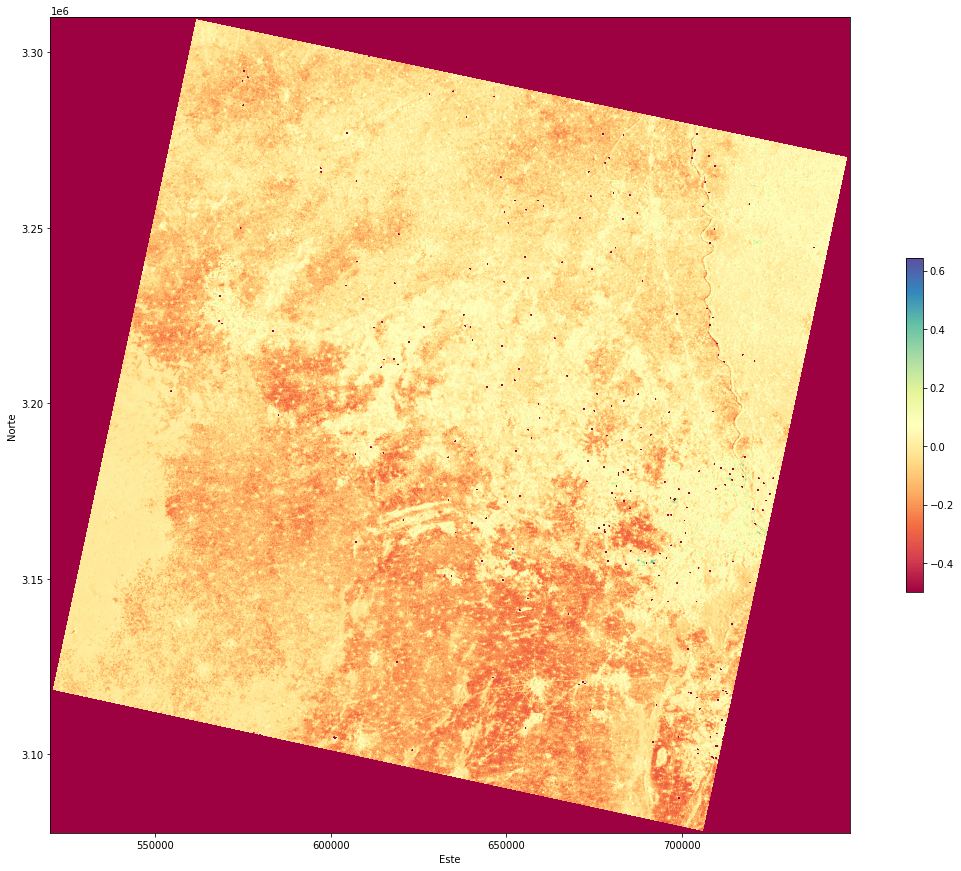

In [ ]:
plotNDVI(path_NDVIChange_19_22,extentArray,-0.5,'Spectral')

Create Contourlines

In [ ]:
Dataset_ndvi = gdal.Open(path_NDVIChange_19_22)
ndvi_raster = Dataset_ndvi.GetRasterBand(1)

ogr_ds = ogr.GetDriverByName("ESRI Shapefile").CreateDataSource(contours_NDVIChange_19_22)

prj=Dataset_ndvi.GetProjectionRef()#GetProjection()

srs = osr.SpatialReference(wkt=prj)#
#srs.ImportFromProj4(prj)

contour_shp = ogr_ds.CreateLayer('contour', srs)
field_defn = ogr.FieldDefn("ID", ogr.OFTInteger)
contour_shp.CreateField(field_defn)
field_defn = ogr.FieldDefn("ndviChange", ogr.OFTReal)
contour_shp.CreateField(field_defn)
#Generate Contourlines
gdal.ContourGenerate(ndvi_raster, 0.1, 0, [], 1, -999, contour_shp, 0, 1)
ogr_ds = None